# Trash Classification Model with CNN

## 1. Approach Explanation

In this project, I aim to build a CNN model to classify trash images into specific categories. The CNN model is trained on the "TrashNet" dataset.
- **Justification**: CNNs are well-suited for image classification tasks as they can capture spatial hierarchies in images.
- **Pros**: Overall, the model experienced a significant increase in training accuracy. The training and validation accuracy results were also not much different, indicating that the model did not experience overfitting or underfitting.
- **Cons**: Only using accuracy as an evaluation metric. This does not provide a clear picture of the classification errors (False Positives and False Negatives).
- **Steps**:
 - Load and prepare the dataset.
 - Visualize and analyze the data distribution.
 - Create and train the CNN model.
 - Evaluate the model and discuss any model bias or dataset issues.


## 2. Data Preparation

In [2]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from datasets import load_dataset
from PIL import Image
from collections import Counter
import random
import seaborn as sns

In [3]:
# Load the dataset
ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


In [5]:
# Specify a local directory to store the dataset
save_dir = './trashnet_data'
os.makedirs(save_dir, exist_ok=True)

# Create a folder for each label inside the local directory
label_names = ds['train'].features['label'].names
for label_name in label_names:
    os.makedirs(os.path.join(save_dir, label_name), exist_ok=True)

# Save each image into a folder according to its label
for i, example in enumerate(ds['train']):
    image = example['image']
    label = label_names[example['label']]

    # Specify the path to save the image.
    image_path = os.path.join(save_dir, label, f"image_{i}.jpg")
    image.save(image_path)

In [6]:
# Initialize ImageDataGenerator with training-validation split and augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% data untuk validation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Create generators for training and validation data
train_generator = datagen.flow_from_directory(
    save_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    save_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

Found 4046 images belonging to 6 classes.
Found 1008 images belonging to 6 classes.


## 3. Exploratory Image Analysis

In [7]:
# Displays the label name along with its index number.
label_names = ds['train'].features['label'].names

print("Label List:")
for idx, label_name in enumerate(label_names):
    print(f"{idx} = {label_name}")


Label List:
0 = cardboard
1 = glass
2 = metal
3 = paper
4 = plastic
5 = trash


In [8]:
# Calculate and display the number of samples per class
label_counts = Counter(ds['train']['label'])
print("Number of images per class:")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} images")


Number of images per class:
cardboard: 806 images
glass: 1002 images
metal: 820 images
paper: 1188 images
plastic: 964 images
trash: 274 images


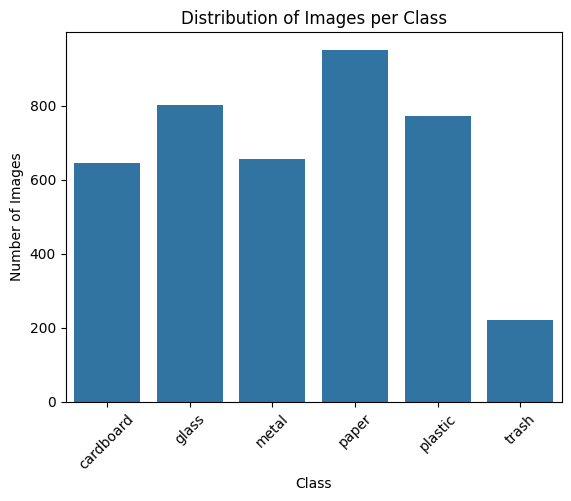

In [9]:
# Visualize the class distribution in the training data
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

sns.countplot(x=class_counts)
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.title('Distribution of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


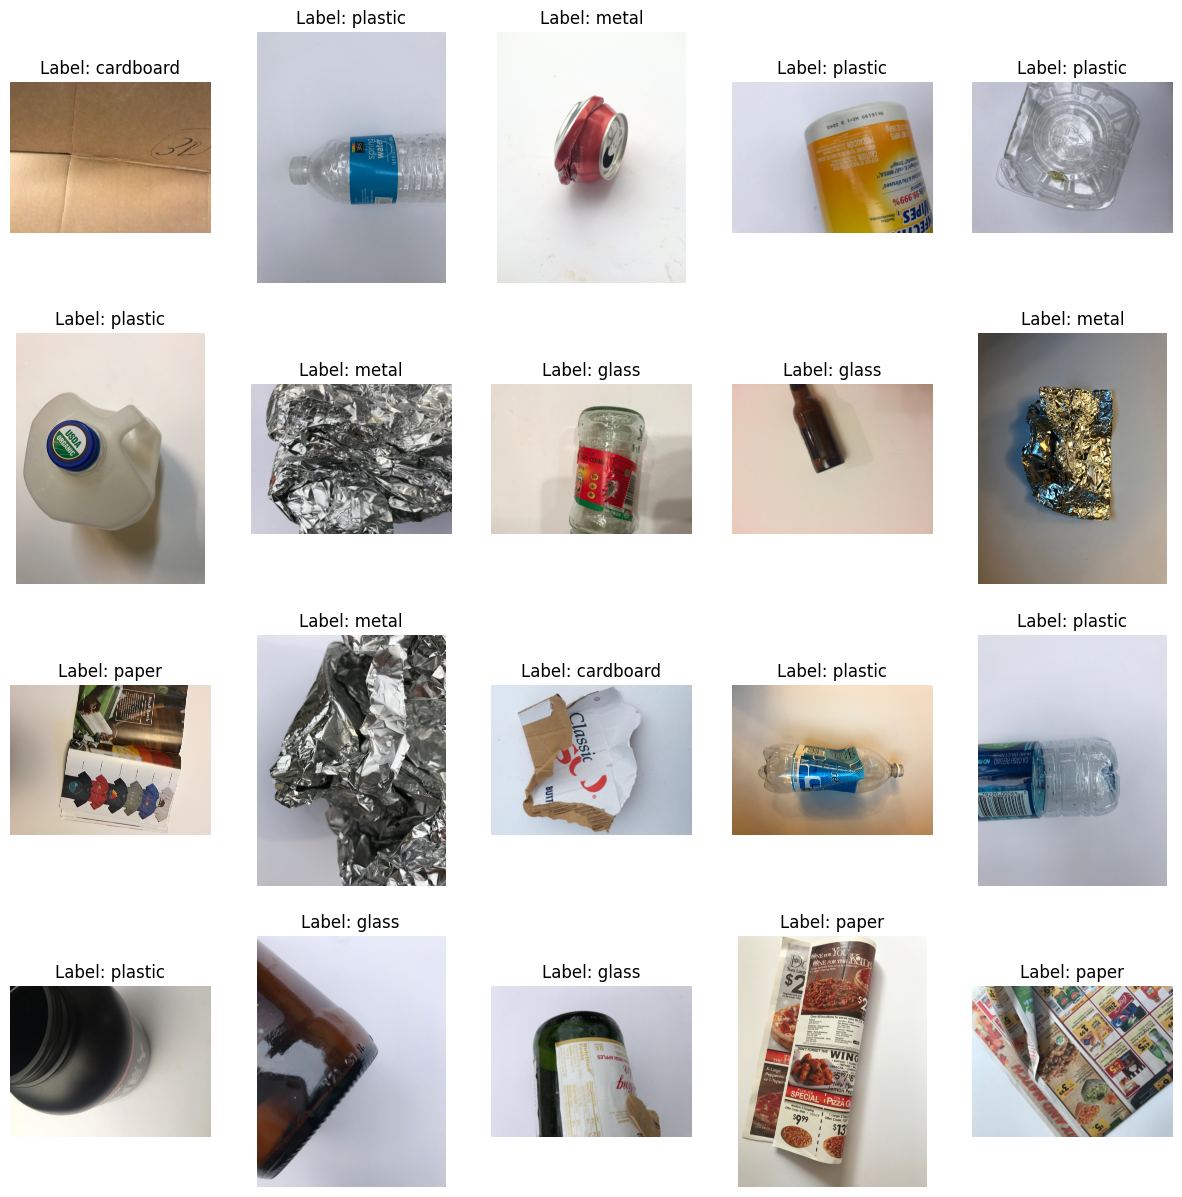

In [10]:
# Function to display 20 random samples from the dataset
def show_random_samples(dataset, num_samples=20):
    random_indices = random.sample(range(len(dataset['train'])), num_samples)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        sample = dataset['train'][idx]
        image = sample['image']
        label = sample['label']

        plt.subplot(4, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label_names[label]}")
        plt.axis("off")
    plt.show()

# Display 20 random samples
show_random_samples(ds)


## 4. Model Training & Evaluation Analysis

In [11]:
# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(label_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,550 (3.98 MB)

 Trainable params: 1,044,550 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Training the model
epochs = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.2874 - loss: 1.6389 - val_accuracy: 0.4385 - val_loss: 1.3561
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.4602 - loss: 1.3293 - val_accuracy: 0.5060 - val_loss: 1.3126
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5164 - loss: 1.2376 - val_accuracy: 0.5308 - val_loss: 1.1841
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.5667 - loss: 1.1121 - val_accuracy: 0.4395 - val_loss: 1.3179
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5281 - loss: 1.1991 - val_accuracy: 0.5863 - val_loss: 1.0424
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6143 - loss: 0.9986 - val_accuracy: 0.6032 - val_loss: 1.0010
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6299 - loss: 0.9857 - val_accuracy: 0.5833 - val_loss: 1.0800
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6653 - loss: 0.8965 - val_accuracy: 0.623

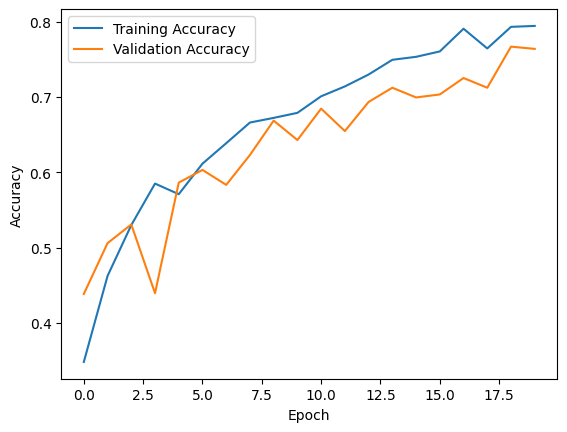

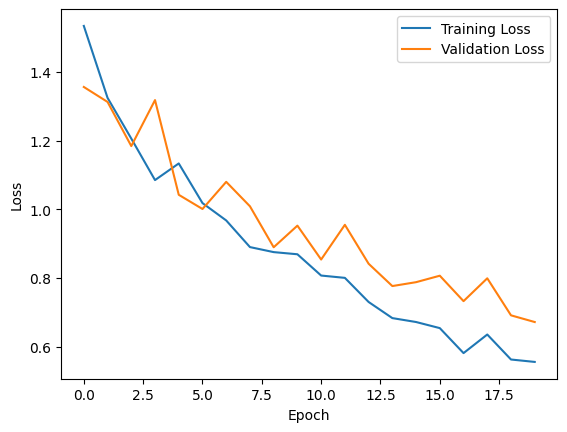

In [15]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Evaluating the model on the validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7544 - loss: 0.7229
Validation Loss: 0.6690147519111633
Validation Accuracy: 0.7658730149269104


In [17]:
# Saving the trained model
model.save('trash_classification_model.h5')

## 5. Additional Insights

The model shows varying levels of accuracy for each class, possibly due to class imbalance or challenging visual distinctions.
- **Model Bias**: The *‘trash’* class has less data than the other five data classes. This may lead to a bias where the model has a harder time classifying *‘trash’* images than other classes.
- **Dataset Issues**: The dataset's image quality, variation, and potential class imbalance could be factors affecting model performance. Further analysis and data augmentation could mitigate these issues.